In [1]:
import numpy as np

import matplotlib.pyplot as plt

from M1S_tools import ZernikeMaskedFit

plt.jet()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Figure size 640x480 with 0 Axes>

## displace the surface geometrically, and project displacements to surface normal

translate M1S1 in radial direction (along +y of M1S1 coordinate system)

In [2]:
def surfFunc(r2):
    return r2/(radius_of_curvature+np.sqrt(radius_of_curvature**2-(1+conic)*r2))

n_of_zernikes = 28
r_S1_center_in_S7 = 8.710 #distance to S1 optical axis in m
diameter_of_CA = 8.365 #CA diamter in m
radius_of_curvature = 36.000 #radius of curvature in m
conic = -0.998286
radius_of_CA = diameter_of_CA/2.0
y_S1_center = r_S1_center_in_S7
x_S1_center = 0
n_nodes_along_radius = 100 #number of grid points along radius (including center)
xvec = np.arange(-radius_of_CA, radius_of_CA+1e-6, 
                 radius_of_CA/n_nodes_along_radius)+x_S1_center
yvec = np.arange(-radius_of_CA, radius_of_CA+1e-6, 
                 radius_of_CA/n_nodes_along_radius)+y_S1_center
x_in_parent,y_in_parent = np.meshgrid(xvec, yvec)
r2_in_parent = x_in_parent**2+y_in_parent**2
z = surfFunc(r2_in_parent)
mask = np.zeros_like(z)
mask[np.sqrt((x_in_parent-x_S1_center)**2+(y_in_parent-y_S1_center)**2)<radius_of_CA]=1
z[mask==0] = np.nan

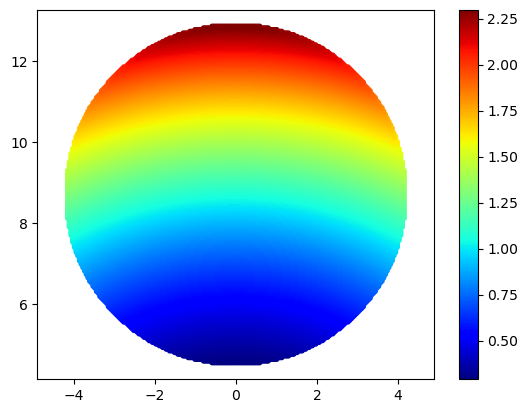

In [3]:
plt.scatter(x_in_parent,y_in_parent, 10, z)
plt.axis('equal')
plt.colorbar();

In [4]:
x_in_S1, y_in_S1 = np.meshgrid(xvec-x_S1_center, yvec-y_S1_center)

### Use the derivatives on the surface to get the surface normal unit vectors

In [5]:
e = 1e-6
zx = surfFunc((x_in_parent+e)**2+y_in_parent**2)
ux1=-np.sin(np.arctan((zx - z)/e))
zy = surfFunc(x_in_parent**2+(y_in_parent+e)**2)
uy1=-np.sin(np.arctan((zy - z)/e))
uz1=np.sqrt(1-ux1*ux1-uy1*uy1)
ux = ux1
uy = uy1
uz = uz1

#The below can be a good sanity check (which helps confirm we are not getting the signs confused)
if 0:
    #get surface normal vectors by drawing a arrow from a node to the center of curvature 
    #(OSS coordinate=(0,0,radius_of_curvature))
    ux = 0-x_in_parent
    uy = 0-y_in_parent
    uz = radius_of_curvature-z
    ur = np.sqrt(ux**2+uy**2+uz**2)
    ux /= ur
    uy /= ur
    uz /= ur

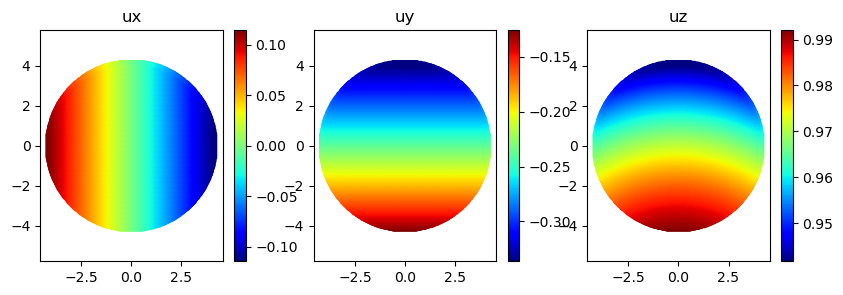

In [6]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
img = ax[0].scatter(x_in_S1,y_in_S1,10, c=ux)
ax[0].axis('equal')
ax[0].set_title('ux')
fig.colorbar(img, ax=ax[0]);

img = ax[1].scatter(x_in_S1,y_in_S1,10, c=uy)
ax[1].axis('equal')
ax[1].set_title('uy')
fig.colorbar(img, ax=ax[1]);

img = ax[2].scatter(x_in_S1,y_in_S1,10, c=uz)
ax[2].axis('equal')
ax[2].set_title('uz')
fig.colorbar(img, ax=ax[2]);

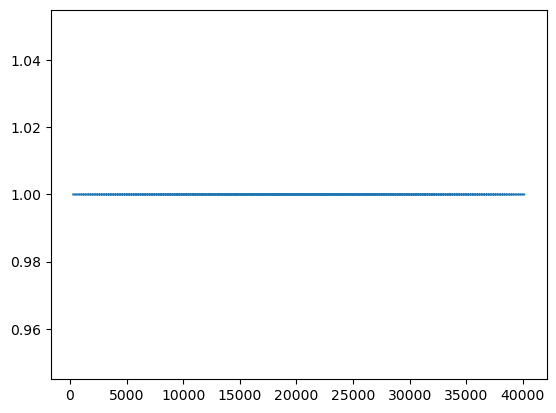

In [7]:
#verify that these are unit vectors
plt.plot(np.sqrt(ux**2+uy**2+uz**2).flatten())

## Ty first, (then we will do Tx, Tz, Rx, Ry, Rz)

#### Radial shift of 1mm (we shift this along y-axis of M1-S1; the angle between x/y plane of M1-S1 and x/y plane of M1-S7 is 13.60 deg)

The angle between M1S1 back plate and x/y plane of M1-S7 is 13.52 deg.

### same displacement vector for every node (so we only calculate this for S1 center!!!)

In [8]:
#for S1 center
x0 = x_S1_center
y0 = y_S1_center
r2_0 = x0**2+y0**2
z0 = surfFunc(r2_0)

In [9]:
tt = 1e-3 #shift of 1mm
realTheta = np.rad2deg(np.arctan((surfFunc(x0**2+(y0+e)**2)-z0)/e))
print(realTheta, ' vs 13.601685 #theta_M1, see GMT-REF-00189, Sec 3.8')
#realTheta = 13.522 #theta_B, see GMT-REF-00189, Sec 3.8 #if the radial shift is along the back surface

13.601685287856892  vs 13.601685 #theta_M1, see GMT-REF-00189, Sec 3.8


In [10]:
tx = 0
ty = tt*np.cos(np.radians(realTheta))
tz = tt*np.sin(np.radians(realTheta))

In [11]:
tn = tx*ux+ty*uy+tz*uz #inner product

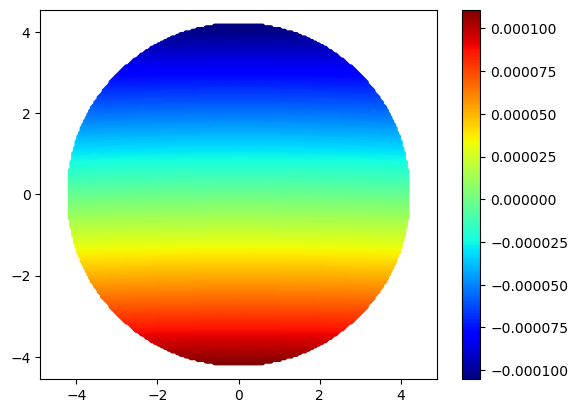

In [12]:
plt.scatter(x_in_S1,y_in_S1, 10, c=tn)
plt.axis('equal')
plt.colorbar();

In [13]:
xfit = x_in_S1/radius_of_CA
yfit = y_in_S1/radius_of_CA
zer_ty = ZernikeMaskedFit(tn, xfit, yfit, n_of_zernikes, mask, 0)*1e9 #turn m into nm

In [14]:
print(zer_ty[4-1], np.sqrt(zer_ty[5-1]**2 + zer_ty[6-1]**2), np.sqrt(zer_ty[7-1]**2 + zer_ty[8-1]**2))
print('table col1 = 799, 539, 49')
print('table col2 = __, 1280, 168')

179.55049298178395 917.3078518255537 49.94332976476499
table col1 = 799, 539, 49
table col2 = __, 1280, 168


In [15]:
zer_ty

array([ 3.13305730e+02, -1.93370593e-04, -5.47442838e+04,  1.79550493e+02,
       -2.19621413e-06, -9.17307852e+02,  4.99433298e+01,  1.51156764e-06,
       -5.51888130e+01,  4.73531175e-07, -1.03198855e+00,  2.59187908e+00,
       -2.22687079e-07, -9.45169969e-01, -6.66159226e-07,  6.16907099e-07,
       -5.67522626e-02,  8.38466102e-07,  6.04110063e-02, -6.70851947e-08,
       -6.08412451e-02,  2.85662404e-03,  2.62942320e-08, -6.94715394e-03,
        6.01951164e-07,  3.88940109e-03, -8.60237767e-07, -6.90996701e-03])

In [16]:
np.mean(tn[mask==1])*1e9

322.36200636021505

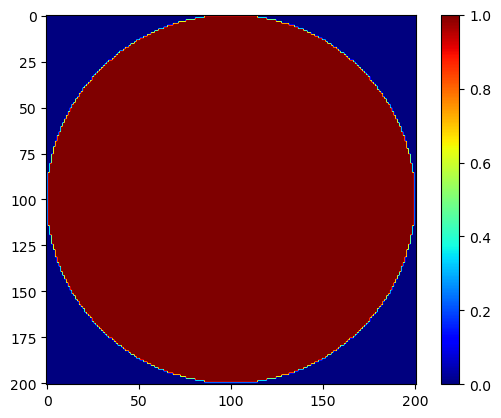

In [17]:
plt.imshow(mask)
plt.colorbar();

## Check Christoph's 1mm radial shift (not duplicating rb2Zn_check_Christoph.ipynb, because here we also do interpolation and make fits)

In [18]:
import scipy.io
mat2 = scipy.io.loadmat('Bo2.mat')

In [19]:
mat2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'elongations', 'inputHP', 'normalDisp', 'x', 'y', 'z'])

In [20]:
x=np.array(mat2['x'])/radius_of_CA
y=np.array(mat2['y'])/radius_of_CA
d=np.array(mat2['normalDisp'])

In [21]:
from scipy.interpolate import griddata
dd = griddata(np.hstack((x,y)), d, (xfit, yfit), method='nearest')

In [22]:
# This takes several minutes to run (and a lot of CPU). But the results are very close to the griddata interpolation
#from scipy.interpolate import RBFInterpolator
#rbf = RBFInterpolator(np.hstack((x,y)), d, epsilon=2)
# z_i = rbf(np.hstack((xfit[:].reshape(201*201,1), yfit[:].reshape(201*201,1))))
# ddd = z_i.reshape((201, 201))

In [23]:
ddd = dd.reshape((2*n_nodes_along_radius+1, 2*n_nodes_along_radius+1))
print(ddd.shape)

(201, 201)


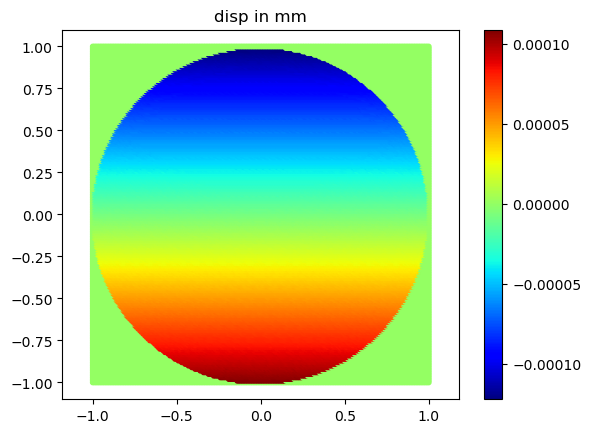

In [24]:
plt.scatter(xfit,yfit,10,c=ddd*mask) #in meter
plt.axis('equal')
plt.title('disp in mm')
plt.colorbar();

In [25]:
zer2 = ZernikeMaskedFit(ddd, yfit, xfit, n_of_zernikes, mask, 0)*1e9 #turn m into nm

In [26]:
print(zer_ty[4-1], np.sqrt(zer_ty[5-1]**2 + zer_ty[6-1]**2), np.sqrt(zer_ty[7-1]**2 + zer_ty[8-1]**2))
print(zer2[4-1], np.sqrt(zer2[5-1]**2 + zer2[6-1]**2), np.sqrt(zer2[7-1]**2 + zer2[8-1]**2))
print('table col1 = 799, 539, 49')
print('table col2 = __, 1280, 168')

179.55049298178395 917.3078518255537 49.94332976476499
15.324149930344696 19.6209435881039 6.5695748309277775
table col1 = 799, 539, 49
table col2 = __, 1280, 168


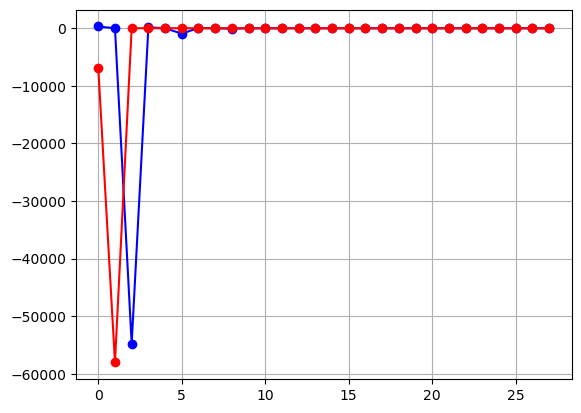

In [27]:
plt.plot(zer_ty,'-ob')
plt.plot(zer2, '-or')
plt.grid();

In [28]:
zer2

array([-6.85083276e+03, -5.80237529e+04,  1.27986777e+00,  1.53241499e+01,
       -2.99840885e-01,  1.96186524e+01, -1.69779000e-01,  6.56738065e+00,
       -6.99990607e-02,  2.04588208e+00, -1.13972788e-01,  3.14212637e-01,
       -3.33951674e-01, -4.06055457e-01, -1.39449342e-01, -7.73914084e-01,
       -4.90292057e-01, -9.41256892e-01,  1.37631735e-01,  1.04013555e+00,
       -1.15003819e-01, -5.82900223e-01, -1.86414379e-01,  5.04829416e-01,
        1.99820666e-01,  9.97300397e-01, -2.06590297e-01, -5.77031280e-01])

In [29]:
mask[np.sqrt((x_in_S1)**2+(y_in_S1)**2)>0.98*radius_of_CA]=np.nan
diff = (tn-ddd)*mask
#diff[abs(diff)>0.02]=0

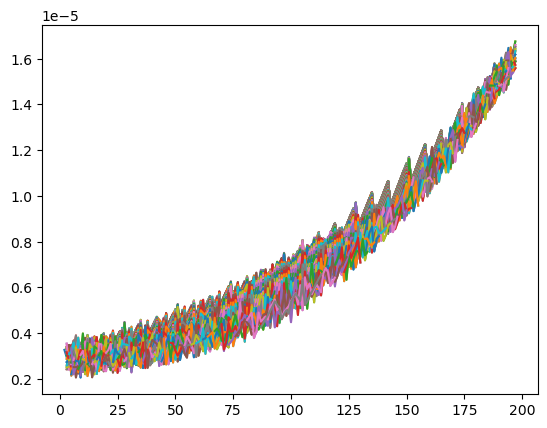

In [30]:
plt.plot(diff);

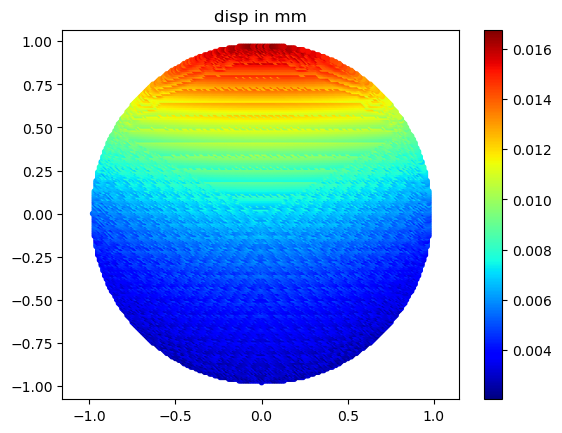

In [31]:
plt.scatter(xfit,yfit,10,c=diff*1e3) #turn meter into mm
plt.axis('equal')
plt.title('disp in mm')
plt.colorbar();